<a href="https://colab.research.google.com/github/elleneee/Fraud-Risk-Model-and-Privacy-Analysis/blob/main/Dataset%20EDA%20and%20preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read in the bank simulation data
data = pd.read_csv("bs140513_032310.csv")

# Preprocessing steps
# 1. Remove columns with constant values
data = data.drop(['zipcodeOri', 'zipMerchant'], axis=1)

# 2. Clean string columns by removing quotes
columns_to_clean = ['customer', 'age', 'gender', 'merchant', 'category']
for col in columns_to_clean:
    # Remove both single quotes and double quotes
    data[col] = data[col].str.strip("'").str.strip('"')

# 3. Remove 'es_' prefix from category column
data['category'] = data['category'].str.replace('es_', '', regex=False)

# 4. Remove rows where gender is Unknown ('U')
data = data[data['gender'] != 'U']

# 5. Replace 'U' with '7' in Age column
data.loc[data['age'] == 'U', 'age'] = '7'

# 6. Create Amount Thresholds
def get_amount_threshold(amount):
    if amount <= 500:
        return '0-500'
    elif amount <= 1000:
        return '500-1000'
    elif amount <= 1500:
        return '1000-1500'
    elif amount <= 2000:
        return '1500-2000'
    elif amount <= 2500:
        return '2000-2500'
    elif amount <= 3000:
        return '2500-3000'
    else:
        return '>3000'

data['amount_thresh'] = data['amount'].apply(get_amount_threshold)

# Display first few rows of processed data
print("\nFirst few rows of processed data:")
print(data.head())

# Number of unique customers
unique_customers = data['customer'].nunique()
print(f"Total number of unique customers: {unique_customers:,}")

# Count unique merchants
unique_merchants = data['merchant'].nunique()
print(f"Total number of unique merchants: {unique_merchants:,}")


First few rows of processed data:
   step     customer age gender     merchant        category  amount  fraud  \
0     0  C1093826151   4      M   M348934600  transportation    4.55      0   
1     0   C352968107   2      M   M348934600  transportation   39.68      0   
2     0  C2054744914   4      F  M1823072687  transportation   26.89      0   
3     0  C1760612790   3      M   M348934600  transportation   17.25      0   
4     0   C757503768   5      M   M348934600  transportation   35.72      0   

  amount_thresh  
0         0-500  
1         0-500  
2         0-500  
3         0-500  
4         0-500  
Total number of unique customers: 4,109
Total number of unique merchants: 50


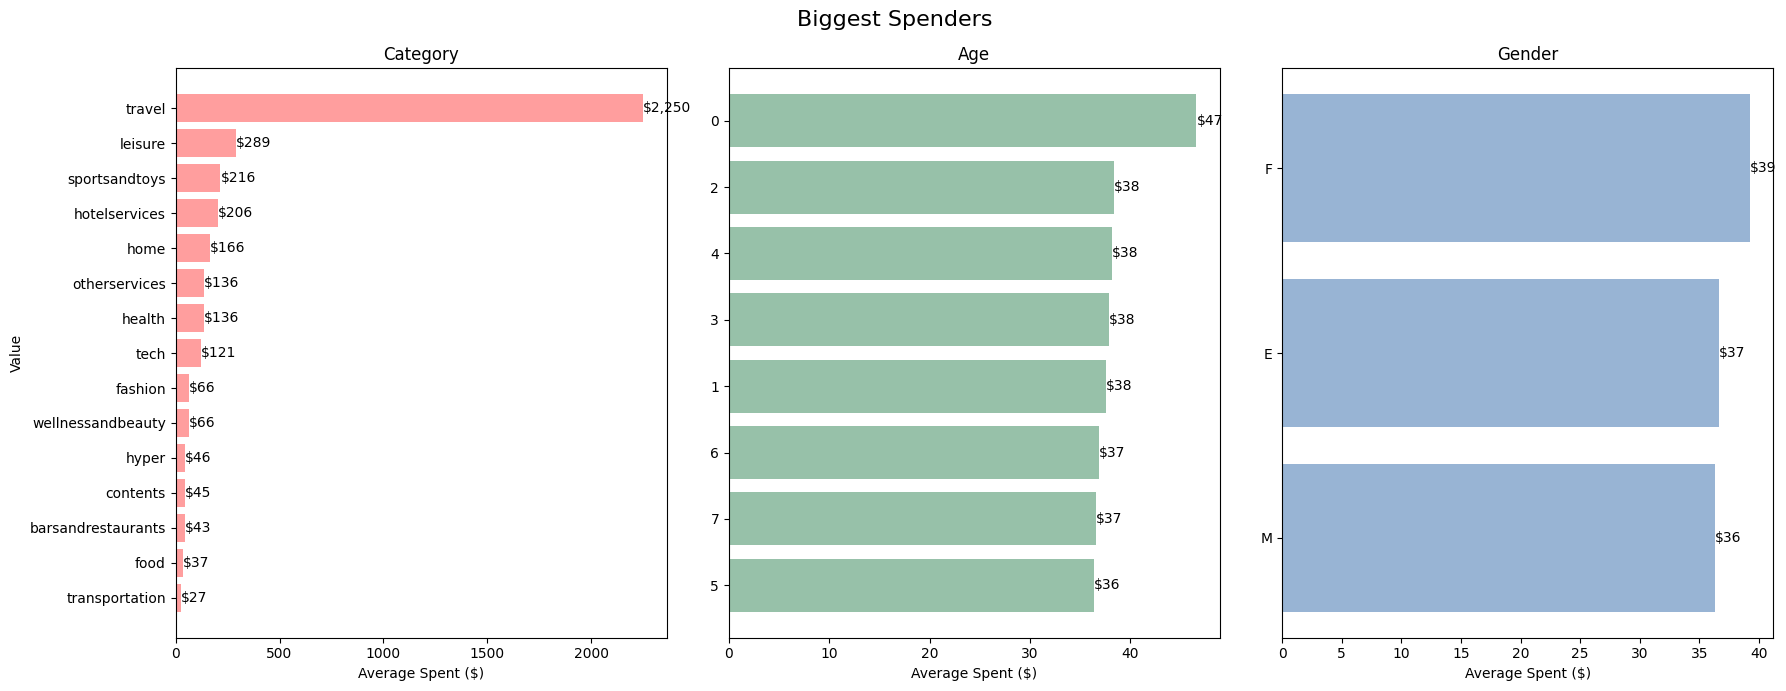


Average Spending by Gender:
  Value  avg_spent  Metric
0     E  36.627623  gender
1     F  39.213044  gender
2     M  36.308094  gender

Average Spending by Age:
  Value  avg_spent Metric
0     0  46.602896    age
1     1  37.544105    age
2     2  38.366811    age
3     3  37.886316    age
4     4  38.201522    age
5     5  36.426231    age
6     6  36.865624    age
7     7  36.627623    age

Average Spending by Category:
                 Value    avg_spent    Metric
0   barsandrestaurants    43.462972  category
1             contents    44.547571  category
2              fashion    65.669814  category
3                 food    37.070752  category
4               health   135.669381  category
5                 home   165.702586  category
6        hotelservices   205.614249  category
7                hyper    45.972229  category
8              leisure   288.911303  category
9        otherservices   135.881524  category
10       sportsandtoys   215.715280  category
11                te

In [ ]:
# Calculate average spending by gender
gender_spending = data.groupby('gender')['amount'].mean().reset_index()
gender_spending['Metric'] = 'gender'
gender_spending = gender_spending.rename(columns={'gender': 'Value', 'amount': 'avg_spent'})

# Calculate average spending by age
age_spending = data.groupby('age')['amount'].mean().reset_index()
age_spending['Metric'] = 'age'
age_spending = age_spending.rename(columns={'age': 'Value', 'amount': 'avg_spent'})

# Calculate average spending by category
category_spending = data.groupby('category')['amount'].mean().reset_index()
category_spending['Metric'] = 'category'
category_spending = category_spending.rename(columns={'category': 'Value', 'amount': 'avg_spent'})

# Combine all dataframes
combined_data = pd.concat([gender_spending, age_spending, category_spending])

# Create the visualization
plt.figure(figsize=(18, 7))

# Create subplots for each metric
metrics = ['category', 'age', 'gender']
colors = ['#FF9E9E', '#97C1A9', '#98B4D4']  # Example colors, adjust as needed

for idx, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, idx)

    # Filter data for current metric
    metric_data = combined_data[combined_data['Metric'] == metric].copy()

    # Sort by average spent
    metric_data = metric_data.sort_values('avg_spent')

    # Create horizontal bar plot
    bars = plt.barh(y=range(len(metric_data)),
                   width=metric_data['avg_spent'],
                   color=colors[idx-1])

    # Add value labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width(),
                bar.get_y() + bar.get_height()/2,
                f'${metric_data.iloc[i]["avg_spent"]:,.0f}',
                va='center')

    # Customize plot
    plt.title(metric.capitalize())
    plt.xlabel('Average Spent ($)')
    if idx == 1:
        plt.ylabel('Value')

    # Set y-axis labels
    plt.yticks(range(len(metric_data)), metric_data['Value'])

# Adjust layout
plt.suptitle('Biggest Spenders', fontsize=16)

plt.tight_layout()

# Show plot
plt.show()

# Print the numerical results
print("\nAverage Spending by Gender:")
print(gender_spending)
print("\nAverage Spending by Age:")
print(age_spending)
print("\nAverage Spending by Category:")
print(category_spending)

<Figure size 1800x700 with 0 Axes>

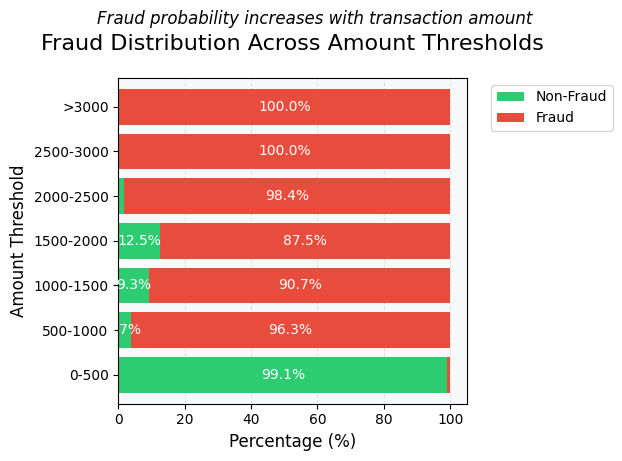


Fraud Distribution by Amount Threshold:
               Non-Fraud   Fraud
amount_thresh                   
0-500              99.13    0.87
500-1000            3.74   96.26
1000-1500           9.35   90.65
1500-2000          12.50   87.50
2000-2500           1.56   98.44
2500-3000            NaN  100.00
>3000                NaN  100.00


In [ ]:
# Set figure size
plt.figure(figsize=(18, 7))

# Define the order of amount thresholds
threshold_order = ['0-500', '500-1000', '1000-1500', '1500-2000',
                  '2000-2500', '2500-3000', '>3000']

# Calculate percentage of fraud for each amount threshold
fraud_percentages = (data.groupby('amount_thresh')['fraud']
                    .value_counts(normalize=True)
                    .mul(100)
                    .unstack()
                    .reindex(threshold_order))

# Rename columns for clarity
fraud_percentages.columns = ['Non-Fraud', 'Fraud']

# Create horizontal stacked bar plot
ax = fraud_percentages.plot(kind='barh',
                          stacked=True,
                          color=['#2ecc71', '#e74c3c'],  # Green for non-fraud, Red for fraud
                          width=0.8)

# Customize the plot
plt.title('Fraud Distribution Across Amount Thresholds',
         fontsize=16,
         pad=20)
plt.suptitle('Fraud probability increases with transaction amount',
            y=0.95,
            fontsize=12,
            style='italic')

# Format axes
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Amount Threshold', fontsize=12)

# Add percentage labels on bars
for c in ax.containers:
    # Add percentage labels in the middle of each segment
    labels = [f'{v:.1f}%' if v >= 2 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=10, color='white')

# Customize legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Set background color
ax.set_facecolor('#f8f9fa')
plt.gca().set_axisbelow(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print the actual percentages
print("\nFraud Distribution by Amount Threshold:")
print(fraud_percentages.round(2))

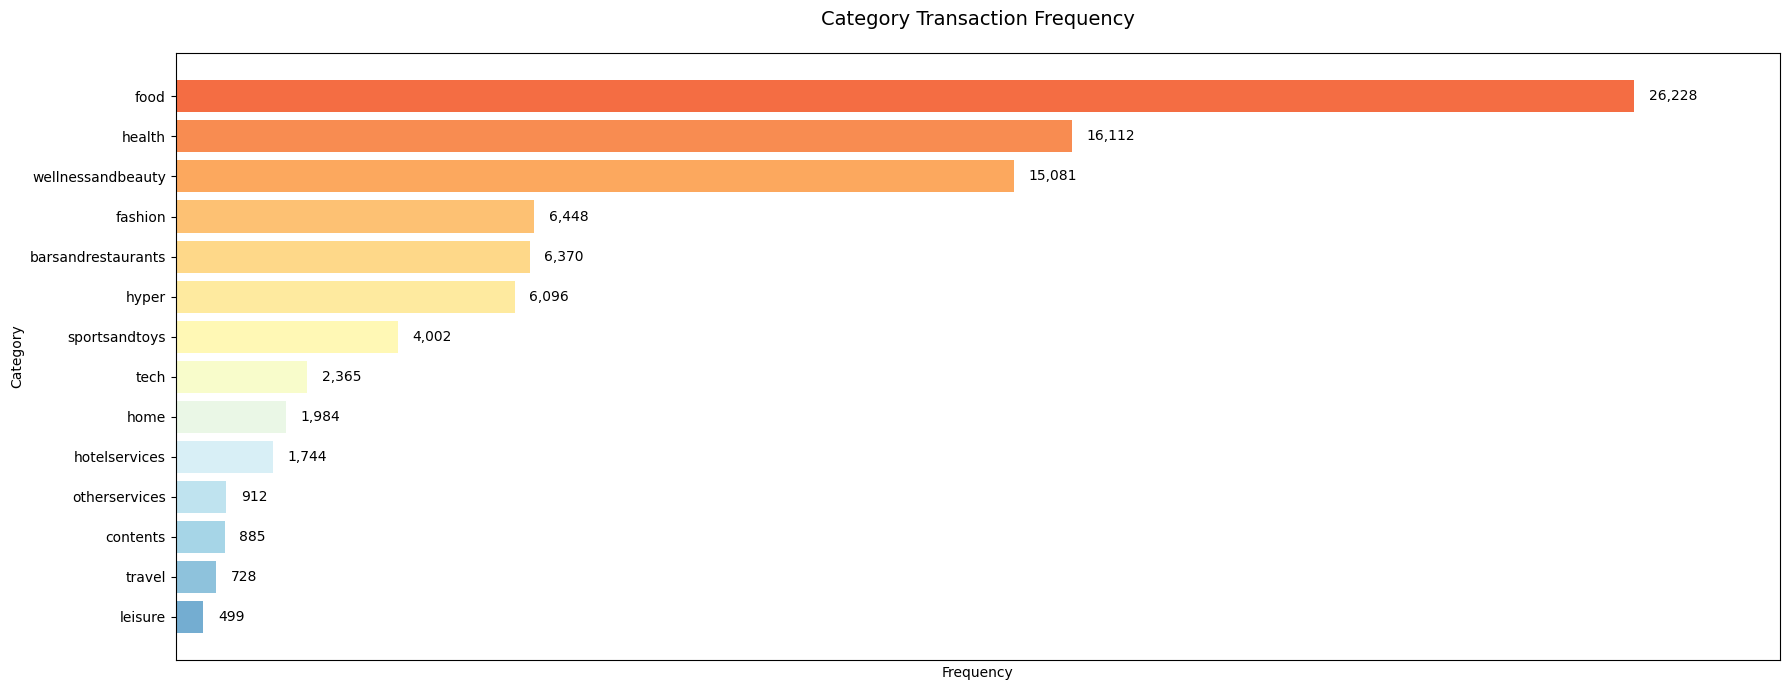


Transaction Counts by Category:
              category  count
3                 food  26228
4               health  16112
13   wellnessandbeauty  15081
2              fashion   6448
0   barsandrestaurants   6370
7                hyper   6096
10       sportsandtoys   4002
11                tech   2365
5                 home   1984
6        hotelservices   1744
9        otherservices    912
1             contents    885
12              travel    728
8              leisure    499


In [ ]:


# Set figure size
plt.figure(figsize=(18, 7))

# Calculate counts by category (excluding transportation)
category_counts = (data[data['category'] != 'transportation']
                  .groupby('category')
                  .size()
                  .reset_index(name='count')
                  .sort_values('count', ascending=True))  # Sort for horizontal bars

# Create color gradient
counts = category_counts['count']
colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(counts)))  # Color gradient

# Create horizontal bar plot
bars = plt.barh(y=range(len(category_counts)),
                width=category_counts['count'],
                color=colors)

# Add value labels on bars
for i, bar in enumerate(bars):
    count = int(category_counts.iloc[i]['count'])
    formatted_count = "{:,}".format(count)  # Format number with commas
    plt.text(bar.get_width() + (max(counts) * 0.01),  # Add small padding
            bar.get_y() + bar.get_height()/2,
            formatted_count,
            va='center',
            ha='left',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Customize plot
plt.title('Category Transaction Frequency', pad=20, fontsize=14)


# Set axis labels
plt.xlabel('Frequency')
plt.ylabel('Category')

# Set y-axis ticks
plt.yticks(range(len(category_counts)),
           category_counts['category'])

# Remove x-axis ticks
plt.xticks([])

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()

# Add some padding to the right for labels
plt.margins(x=0.1)

# Show plot
plt.show()

# Print category counts
print("\nTransaction Counts by Category:")
print(category_counts.sort_values('count', ascending=False))

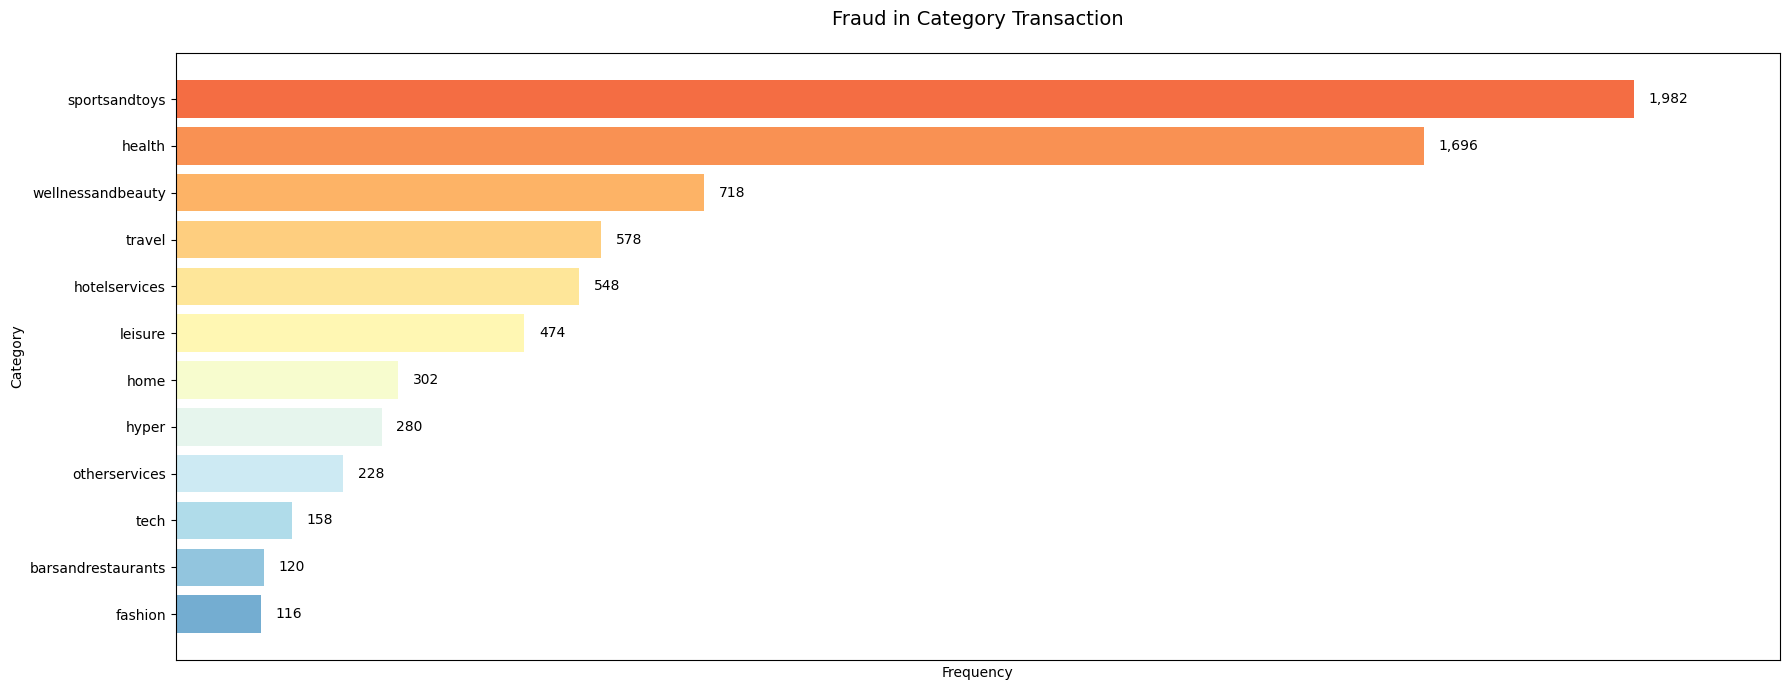


Fraud Counts by Category:
              category  count
8        sportsandtoys   1982
2               health   1696
11   wellnessandbeauty    718
10              travel    578
4        hotelservices    548
6              leisure    474
3                 home    302
5                hyper    280
7        otherservices    228
9                 tech    158
0   barsandrestaurants    120
1              fashion    116


In [ ]:

# Set figure size
plt.figure(figsize=(18, 7))

# Calculate fraud counts by category
fraud_by_category = (data[data['fraud'] == 1]
                    .groupby('category')
                    .size()
                    .reset_index(name='count')
                    .sort_values('count', ascending=True))  # Sort for horizontal bars

# Create color gradient
counts = fraud_by_category['count']
colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(counts)))  # Color gradient from blue to red

# Create horizontal bar plot
bars = plt.barh(y=range(len(fraud_by_category)),
                width=fraud_by_category['count'],
                color=colors)

# Add value labels on bars
for i, bar in enumerate(bars):
    count = int(fraud_by_category.iloc[i]['count'])
    formatted_count = "{:,}".format(count)  # Format number with commas
    plt.text(bar.get_width() + (max(counts) * 0.01),  # Add small padding
            bar.get_y() + bar.get_height()/2,
            formatted_count,
            va='center',
            ha='left',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Customize plot
plt.title('Fraud in Category Transaction', pad=20, fontsize=14)


# Set axis labels
plt.xlabel('Frequency')
plt.ylabel('Category')

# Set y-axis ticks
plt.yticks(range(len(fraud_by_category)),
           fraud_by_category['category'])

# Remove x-axis ticks
plt.xticks([])

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add some padding to the right for labels
plt.margins(x=0.1)

# Show plot
plt.show()

# Print fraud counts by category
print("\nFraud Counts by Category:")
print(fraud_by_category.sort_values('count', ascending=False))

<Figure size 1800x700 with 0 Axes>

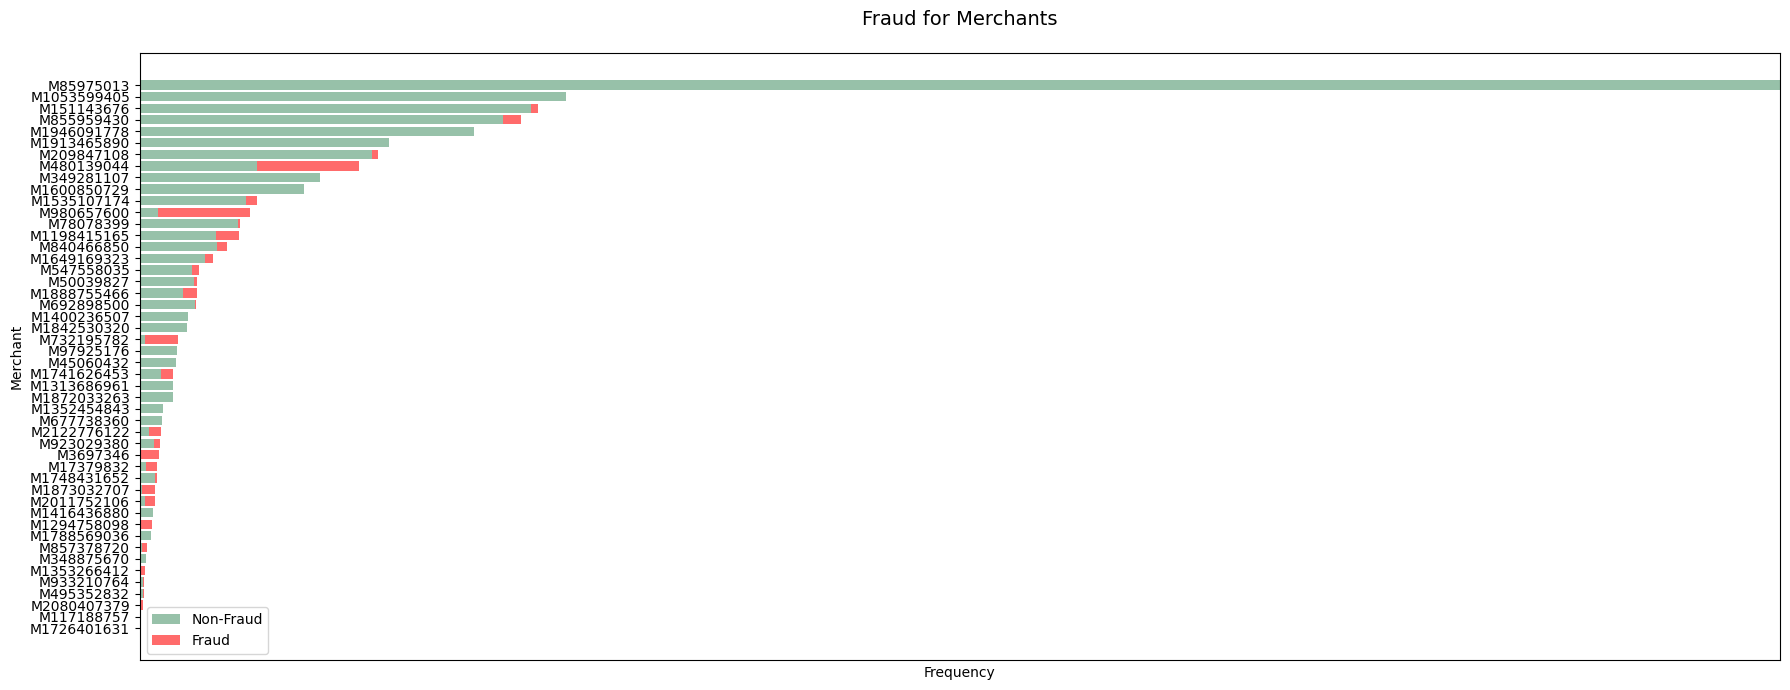


Top Merchants by Fraud Count:
    fraud     merchant  count
67      1   M480139044   1634
79      1   M980657600   1472
72      1   M732195782    518
50      1  M1198415165    358
66      1     M3697346    290


In [ ]:
# Set figure size
plt.figure(figsize=(18, 7))

# Calculate counts by fraud and merchant
merchant_counts = (data.groupby(['fraud', 'merchant'])
                  .size()
                  .reset_index(name='count')
                  .sort_values('count', ascending=False))

# Filter out specific merchants
merchant_counts = merchant_counts[~merchant_counts['merchant'].isin(['M1823072687', 'M348934600'])]

# Create separate dataframes for fraud and non-fraud
fraud_data = merchant_counts[merchant_counts['fraud'] == 1]
non_fraud_data = merchant_counts[merchant_counts['fraud'] == 0]

# Get unique merchants in order of total transactions
merchant_order = (merchant_counts.groupby('merchant')['count']
                 .sum()
                 .sort_values(ascending=True)
                 .index)

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(18, 7))

# Plot non-fraud bars
non_fraud_bars = ax.barh(y=range(len(merchant_order)),
                        width=[non_fraud_data[non_fraud_data['merchant'] == m]['count'].values[0]
                              if m in non_fraud_data['merchant'].values else 0
                              for m in merchant_order],
                        color='#97C1A9',  # Light green
                        label='Non-Fraud')

# Plot fraud bars
fraud_bars = ax.barh(y=range(len(merchant_order)),
                     width=[fraud_data[fraud_data['merchant'] == m]['count'].values[0]
                           if m in fraud_data['merchant'].values else 0
                           for m in merchant_order],
                     color='#FF6B6B',  # Light red
                     left=[non_fraud_data[non_fraud_data['merchant'] == m]['count'].values[0]
                           if m in non_fraud_data['merchant'].values else 0
                           for m in merchant_order],
                     label='Fraud')

# Customize plot
plt.title('Fraud for Merchants', pad=20, fontsize=14)

# Set axis labels
plt.xlabel('Frequency')
plt.ylabel('Merchant')

# Set y-axis ticks
plt.yticks(range(len(merchant_order)), merchant_order)

# Remove x-axis ticks
plt.xticks([])

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print top merchants by fraud count
print("\nTop Merchants by Fraud Count:")
print(fraud_data.head())

